## Imports 

In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row, SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import explode
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col
import time

## Initialize Spark context / Session and Import the Dataset 

In [2]:
spark = SparkSession.builder.appName('Spark_ALS_recommender').getOrCreate()

user_col = ['user_id', 'gender', 'age', 'occupation', 'zip']
user_df = spark.read.format("csv").option("delimiter", "::").option("inferSchema", "true").load("/Users/aditcam/Downloads/ml-1m/users.dat")
col_alias = user_df.columns
user_df = user_df.select([col(col_alias[i]).alias(user_col[i]) for i in range(len(user_col))])

rating_col = ['user_id', 'movie_id', 'rating', 'timestamp']
rating_df = spark.read.format("csv").option("delimiter", "::").option("inferSchema", "true").load("/Users/aditcam/Downloads/ml-1m/ratings.dat")
rating_df = rating_df.select([col(col_alias[i]).alias(rating_col[i]) for i in range(len(rating_col))])

movie_col = ['movie_id', 'title', 'genres']
movie_df = spark.read.format("csv").option("delimiter", "::").option("inferSchema", "true").load("/Users/aditcam/Downloads/ml-1m/movies.dat")
movie_df = movie_df.select([col(col_alias[i]).alias(movie_col[i]) for i in range(len(movie_col))])

## Model Training, crossval and testing

In [3]:
(train, test) = rating_df.randomSplit([0.8, 0.2])

als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True,implicitPrefs=False)

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [100]) \
            .addGrid(als.regParam, [.15]) \
            .addGrid(als.maxIter, [5]) \
            .build()

# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 
print ("Total number of models to be tested: ", len(param_grid))

# Build cross validation using CrossValidator
start = time.time()
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
best_model = cvModel.bestModel
end = time.time()
print('Time taken for training {}s'.format(round(end-start,2)))

print("**Best Model**")
# Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())
# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print('Root Mean Squared Error is {}'.format(RMSE))

movieSubSetRecs = best_model.recommendForAllUsers(3)

Total number of models to be tested:  1
Time taken for training 92.97s
**Best Model**
  Rank: 100
  MaxIter: 5
  RegParam: 0.15
Root Mean Squared Error is 0.9240788661316319


## Outputs 

### Movie recommendations

In [4]:
final_df = movieSubSetRecs \
.withColumn('recommendation',explode(movieSubSetRecs.recommendations)) \
.select(movieSubSetRecs.user_id,col('recommendation.movie_id'),col('recommendation.rating'))

In [5]:
final_df.show(10,False)

+-------+--------+---------+
|user_id|movie_id|rating   |
+-------+--------+---------+
|12     |3382    |5.854477 |
|12     |557     |4.7550344|
|12     |572     |4.5924554|
|26     |3382    |5.189043 |
|26     |572     |4.3411207|
|26     |1851    |3.9044237|
|27     |3382    |6.050927 |
|27     |557     |5.383823 |
|27     |3542    |5.0529943|
|28     |3382    |5.7740617|
+-------+--------+---------+
only showing top 10 rows



### Schemas of all the datasets involved

In [6]:
user_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- occupation: integer (nullable = true)
 |-- zip: string (nullable = true)



In [7]:
rating_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)



In [8]:
movie_df.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [9]:
final_df.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)



### Summary Stats 

In [10]:
user_df.describe().show()

+-------+------------------+------+------------------+-----------------+-----------------+
|summary|           user_id|gender|               age|       occupation|              zip|
+-------+------------------+------+------------------+-----------------+-----------------+
|  count|              6040|  6040|              6040|             6040|             6040|
|   mean|            3020.5|  null|30.639238410596025|8.146854304635761|87986.22464010713|
| stddev|1743.7421445462246|  null|12.895961726906837|6.329511491401687|2499493.295731326|
|    min|                 1|     F|                 1|                0|            00231|
|    max|              6040|     M|                56|               20|            99945|
+-------+------------------+------+------------------+-----------------+-----------------+



In [11]:
rating_df.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|           user_id|          movie_id|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|           1000209|           1000209|           1000209|             1000209|
|   mean| 3024.512347919285|1865.5398981612843| 3.581564453029317| 9.722436954046655E8|
| stddev|1728.4126948999715|1096.0406894572482|1.1171018453732606|1.2152558939916052E7|
|    min|                 1|                 1|                 1|           956703932|
|    max|              6040|              3952|                 5|          1046454590|
+-------+------------------+------------------+------------------+--------------------+



In [12]:
movie_df.describe().show()

+-------+------------------+--------------------+-------+
|summary|          movie_id|               title| genres|
+-------+------------------+--------------------+-------+
|  count|              3883|                3883|   3883|
|   mean|1986.0494463044038|                null|   null|
| stddev|1146.7783494728876|                null|   null|
|    min|                 1|$1,000,000 Duck (...| Action|
|    max|              3952|     eXistenZ (1999)|Western|
+-------+------------------+--------------------+-------+



In [13]:
final_df.describe().show()

+-------+------------------+------------------+------------------+
|summary|           user_id|          movie_id|            rating|
+-------+------------------+------------------+------------------+
|  count|             18120|             18120|             18120|
|   mean|            3020.5| 1773.130518763797| 5.268932872767217|
| stddev|1743.6459035689982|1338.7664796694971|0.8100983781211466|
|    min|                 1|                37|         1.3400229|
|    max|              6040|              3542|          8.630114|
+-------+------------------+------------------+------------------+



In [14]:
from pyspark.sql.functions import *

### Most rated movies

In [15]:
most_rated = rating_df \
.groupBy("movie_id") \
.agg(count("user_id")) \
.withColumnRenamed("count(user_id)", "rating_cnt") \
.sort(desc("rating_cnt"))

In [16]:
most_rated.show(10,False)

+--------+----------+
|movie_id|rating_cnt|
+--------+----------+
|2858    |3428      |
|260     |2991      |
|1196    |2990      |
|1210    |2883      |
|480     |2672      |
|2028    |2653      |
|589     |2649      |
|2571    |2590      |
|1270    |2583      |
|593     |2578      |
+--------+----------+
only showing top 10 rows



In [17]:
most_rated_movies =  most_rated.join(movie_df,most_rated.movie_id == movie_df.movie_id)

In [18]:
most_rated_movies.show(25,False)

+--------+----------+--------+------------------------------------------+--------------------------------+
|movie_id|rating_cnt|movie_id|title                                     |genres                          |
+--------+----------+--------+------------------------------------------+--------------------------------+
|1580    |2538      |1580    |Men in Black (1997)                       |Action|Adventure|Comedy|Sci-Fi  |
|2366    |756       |2366    |King Kong (1933)                          |Action|Adventure|Horror         |
|1088    |687       |1088    |Dirty Dancing (1987)                      |Musical|Romance                 |
|1959    |626       |1959    |Out of Africa (1985)                      |Drama|Romance                   |
|3175    |1728      |3175    |Galaxy Quest (1999)                       |Adventure|Comedy|Sci-Fi         |
|1645    |826       |1645    |Devil's Advocate, The (1997)              |Crime|Horror|Mystery|Thriller   |
|496     |37        |496     |What Ha

### Highest rated movies

In [19]:
high_rated = rating_df \
.groupBy("movie_id") \
.agg(avg(col("rating")),count(col('movie_id'))) \
.withColumnRenamed("avg(rating)", "avg_rating") \
.withColumnRenamed("count(movie_id)", "rating_cnt") \
.sort(desc("avg_rating"),desc("rating_cnt"))

In [20]:
high_rated.show(10,False)

+--------+----------+----------+
|movie_id|avg_rating|rating_cnt|
+--------+----------+----------+
|787     |5.0       |3         |
|3233    |5.0       |2         |
|3280    |5.0       |1         |
|3881    |5.0       |1         |
|3607    |5.0       |1         |
|989     |5.0       |1         |
|3172    |5.0       |1         |
|3382    |5.0       |1         |
|3656    |5.0       |1         |
|1830    |5.0       |1         |
+--------+----------+----------+
only showing top 10 rows



In [21]:
high_rated.join(movie_df,high_rated.movie_id == movie_df.movie_id).sort(desc("avg_rating"),desc("rating_cnt")).show(10,False)

+--------+----------+----------+--------+-----------------------------------------+--------------------+
|movie_id|avg_rating|rating_cnt|movie_id|title                                    |genres              |
+--------+----------+----------+--------+-----------------------------------------+--------------------+
|787     |5.0       |3         |787     |Gate of Heavenly Peace, The (1995)       |Documentary         |
|3233    |5.0       |2         |3233    |Smashing Time (1967)                     |Comedy              |
|3280    |5.0       |1         |3280    |Baby, The (1973)                         |Horror              |
|3881    |5.0       |1         |3881    |Bittersweet Motel (2000)                 |Documentary         |
|3607    |5.0       |1         |3607    |One Little Indian (1973)                 |Comedy|Drama|Western|
|989     |5.0       |1         |989     |Schlafes Bruder (Brother of Sleep) (1995)|Drama               |
|3172    |5.0       |1         |3172    |Ulysses (Uliss

In [22]:
high_rated = rating_df \
.groupBy("movie_id") \
.agg(avg(col("rating")),count(col('movie_id'))) \
.withColumnRenamed("avg(rating)", "avg_rating") \
.withColumnRenamed("count(movie_id)", "rating_cnt") \
.sort(desc('rating_cnt'),desc("avg_rating"))

In [23]:
high_rated.join(movie_df,most_rated.movie_id == movie_df.movie_id).sort(desc('rating_cnt'),desc("avg_rating")).show(10,False)

+--------+------------------+----------+--------+-----------------------------------------------------+-----------------------------------+
|movie_id|avg_rating        |rating_cnt|movie_id|title                                                |genres                             |
+--------+------------------+----------+--------+-----------------------------------------------------+-----------------------------------+
|2858    |4.3173862310385065|3428      |2858    |American Beauty (1999)                               |Comedy|Drama                       |
|260     |4.453694416583082 |2991      |260     |Star Wars: Episode IV - A New Hope (1977)            |Action|Adventure|Fantasy|Sci-Fi    |
|1196    |4.292976588628763 |2990      |1196    |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Drama|Sci-Fi|War  |
|1210    |4.022892819979188 |2883      |1210    |Star Wars: Episode VI - Return of the Jedi (1983)    |Action|Adventure|Romance|Sci-Fi|War|
|480     |3.76384730

### Movies with highly conflicting/polarising reviews 

In [24]:
ratings_sd = rating_df\
.groupBy("movie_id")\
.agg(count("user_id").alias("rating_cnt"), 
     avg(col("rating")).alias("avg_rating"),
     stddev(col("rating")).alias("sd_rating")
    )\
.where("rating_cnt > 50")

In [25]:
ratings_sd.join(movie_df,ratings_sd.movie_id == movie_df.movie_id).sort(desc("sd_rating")).show(10,False)

+--------+----------+------------------+------------------+--------+----------------------------------------------+-----------------------+
|movie_id|rating_cnt|avg_rating        |sd_rating         |movie_id|title                                         |genres                 |
+--------+----------+------------------+------------------+--------+----------------------------------------------+-----------------------+
|1241    |70        |3.357142857142857 |1.4649104863162303|1241    |Braindead (1992)                              |Comedy|Horror          |
|1924    |249       |2.6345381526104417|1.4559983991255796|1924    |Plan 9 from Outer Space (1958)                |Horror|Sci-Fi          |
|2507    |54        |2.9814814814814814|1.4074028099524012|2507    |Breakfast of Champions (1999)                 |Comedy                 |
|2275    |71        |3.3661971830985915|1.4065097289767452|2275    |Six-String Samurai (1998)                     |Action|Adventure|Sci-Fi|
|2362    |53        

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Visualizations

ref : https://towardsdatascience.com/comprehensive-data-explorations-with-matplotlib-a388be12a355

In [27]:
pd_movies_df = movie_df.toPandas()
pd_ratings_df = rating_df.toPandas()
pd_users_df = user_df.toPandas()

We transform the generes column as it will be useful for visualizing the data

In [28]:
pd_movies_df.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
# ref : https://stackoverflow.com/questions/62408093/one-hot-encoding-multiple-categorical-data-in-a-column

### Join every string in every row, split the result, pull out the unique values.
genres = np.unique('|'.join(pd_movies_df['genres']).split('|'))
### Drop 'NA'
genres = np.delete(genres, np.where(genres == 'NA'))

for genre in genres:
    pd_movies_df[genre] = pd_movies_df['genres'].str.contains(genre).astype('int')

pd_movies_df.drop('genres', axis=1, inplace=True)

After one hot encoding the genres for easier visualization

In [30]:
pd_movies_df.head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
df_merged = pd.merge(pd_users_df, pd_ratings_df, how="left", on="user_id")
df_merged = pd.merge(df_merged, pd_movies_df, how="left",on="movie_id")
df_merged.head()

,user_id,gender,age,occupation,zip,movie_id,rating,timestamp,title,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
1,1,F,1,10,48067,661,3,978302109,James and the Giant Peach (1996),0,...,0,0,0,1,0,0,0,0,0,0
2,1,F,1,10,48067,914,3,978301968,My Fair Lady (1964),0,...,0,0,0,1,0,1,0,0,0,0
3,1,F,1,10,48067,3408,4,978300275,Erin Brockovich (2000),0,...,0,0,0,0,0,0,0,0,0,0
4,1,F,1,10,48067,2355,5,978824291,"Bug's Life, A (1998)",0,...,0,0,0,0,0,0,0,0,0,0


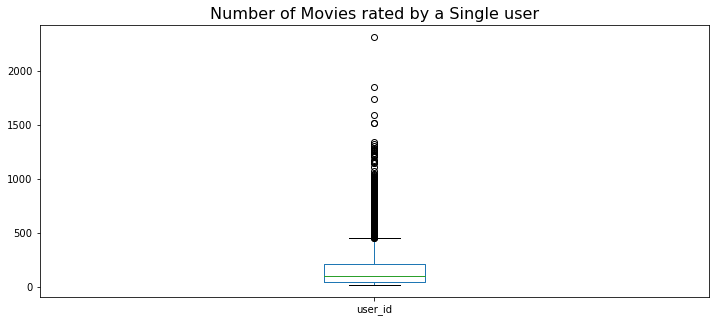

In [32]:
pd_ratings_df.user_id.value_counts().plot.box(figsize=(12, 5))
plt.title("Number of Movies rated by a Single user", fontsize=16)
plt.show()


In [33]:
movies_rated = pd_ratings_df.groupby('user_id').size().sort_values(ascending=False)

In [34]:
display(movies_rated)

user_id
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Length: 6040, dtype: int64

In [35]:
print('Max user movie ratings {}\nMin user ratings {}'.format(2314,20))

Max user movie ratings 2314
Min user ratings 20


### Most Common genre in movies

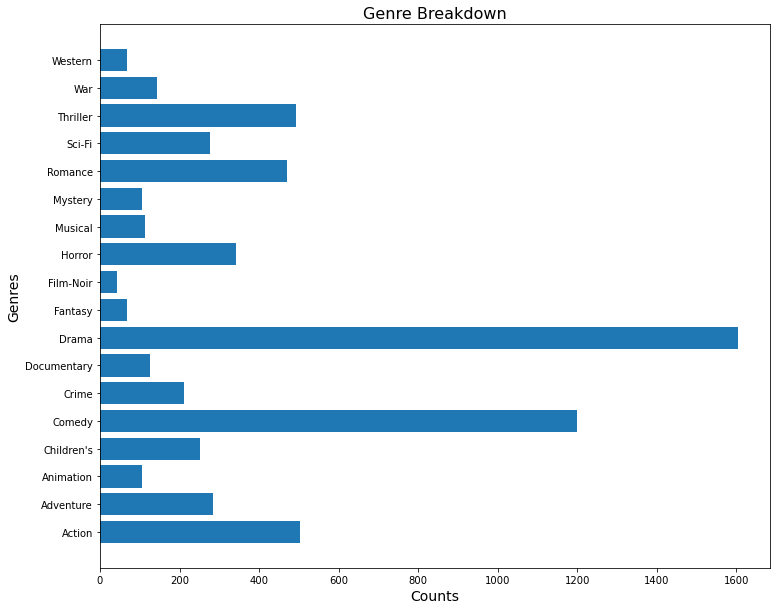

In [37]:
# get the genre names in the dataframe and their counts
temp = pd_movies_df[list(genres)]
label= temp.sum().index
label_counts= temp.sum().values
# plot a bar chart
plt.figure(figsize=(12, 10))
plt.barh(y= label, width= label_counts)
plt.title("Genre Breakdown", fontsize=16)
plt.ylabel("Genres", fontsize=14)
plt.xlabel("Counts", fontsize=14)
plt.show()

###  Genre Breakdown across genders

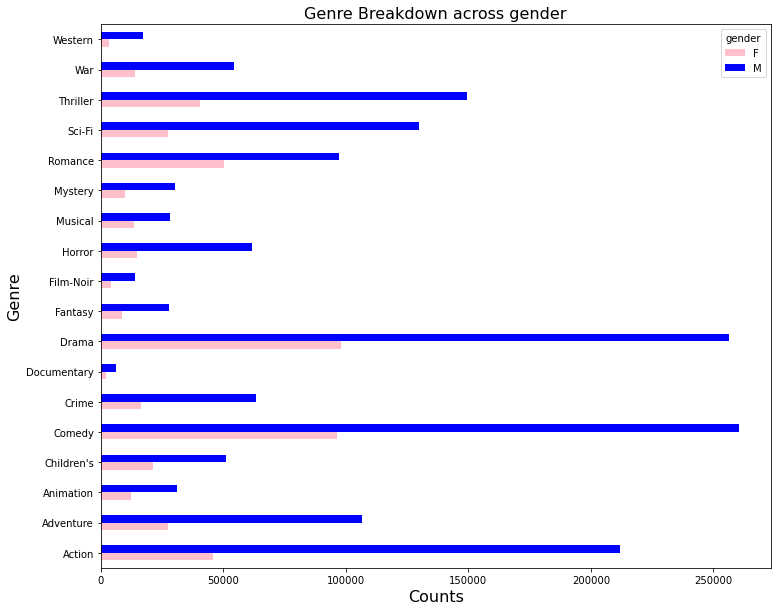

In [38]:
df_merged[list(genres)+["gender"]].groupby("gender").sum().T.plot(kind="barh", figsize=(12,10), color=["pink", "blue"])
plt.xlabel("Counts",fontsize=16)
plt.ylabel("Genre", fontsize=16)
plt.title("Genre Breakdown across gender", fontsize=16)
plt.show()

###  Genre Breakdown across genders within children ( i.e. age less than 18 )

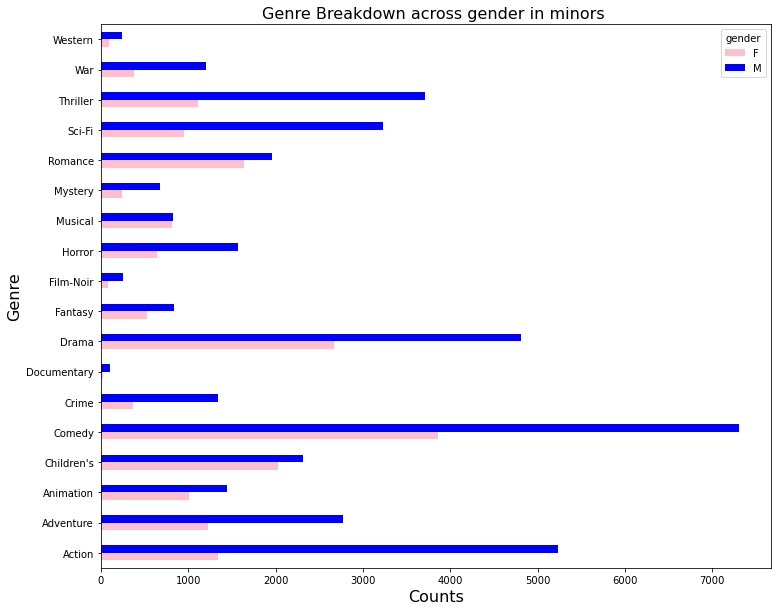

In [39]:
df_merged[df_merged['age']<18][list(genres)+["gender"]].groupby("gender").sum().T.plot(kind="barh", figsize=(12,10), color=["pink", "blue"])
plt.xlabel("Counts",fontsize=16)
plt.ylabel("Genre", fontsize=16)
plt.title("Genre Breakdown across gender in minors ", fontsize=16)
plt.show()